#### Imports and installs

In [7]:
!pip install wordcloud

In [8]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 653.1 kB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [9]:
!pip install langdetect

In [10]:
# Imports

# General
import gzip
import random
import json
import pandas as pd
import numpy as np

# Visualization
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

# NLP
from collections import Counter
import spacy
from nltk import ngrams
from gensim.models import Word2Vec

# Varied
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from langdetect import detect, DetectorFactory

## Preparing the dataset

#### Extract a subsample of data

In [11]:
def extract_data(file_path, target_rows, output_file):

  '''This function takes a path to a file to extract data from and
  the number of rows to extract from the file. It extracts
  rows randomly and saves them to an outputfile in json format.'''

  # Reservoir sampling to randomly pick target_rows lines
  sampled_lines = []
  with gzip.open(file_path, 'rt', encoding='utf-8') as f:
      for i, line in enumerate(f):
          if i < target_rows:
              # Initially fill the reservoir
              sampled_lines.append(line)
          else:
              # Randomly replace elements in the reservoir
              j = random.randint(0, i)
              if j < target_rows:
                  sampled_lines[j] = line

  # Save the sampled lines to a JSON file
  with open(output_file, 'w', encoding='utf-8') as outfile:
    for line in sampled_lines:
      outfile.write(line)

In [12]:
# Sample data from the original data file
extract_data("Industrial_and_Scientific.jsonl.gz", 80000, "sampled_data.json")

<b>Comment: </b>The following sentiment analysis will be only applied on a subset of the original dataset due to processing costs. Here I select 50 000 samples, so that later on I can downsample the dataset to make it balanced by rating category.

#### Basic dataset info

In [13]:
# Read the JSONL file into a DataFrame
df = pd.read_json("sampled_data.json", lines=True)

In [14]:
# Get basic dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   rating             80000 non-null  int64         
 1   title              80000 non-null  object        
 2   text               80000 non-null  object        
 3   images             80000 non-null  object        
 4   asin               80000 non-null  object        
 5   parent_asin        80000 non-null  object        
 6   user_id            80000 non-null  object        
 7   timestamp          80000 non-null  datetime64[ns]
 8   helpful_vote       80000 non-null  int64         
 9   verified_purchase  80000 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(2), object(6)
memory usage: 5.6+ MB


<b>Comment: </b> No missing values.

In [15]:
# Show dataframe
df.sample(5, random_state=1)

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
7126,5,Great for the price!,I have been using this stethoscope at work eve...,[],B073FQL72B,B073FQL72B,AEKBUIZV3YEYC7SJG6YQXUUO2GUQ,2018-07-13 05:33:30.080,0,True
46624,5,I'm from Guatemala and this product is not eas...,I'm from Guatemala and this product is not eas...,[],B077P4GYBX,B09PNGJB83,AFW27IO7KSCX3K5TYTKUZQVCHTEQ,2017-12-19 03:24:57.385,0,True
67020,5,Works great.,"Works great, used it on my water well as my ol...",[],B007MZWASG,B0CB3XTZRW,AH3ABYV4K6WLCHPVIFAH4MFMB6EA,2022-01-18 23:57:14.653,0,True
67356,5,Way better than expected,I bought this with not very high expectations ...,[],B000GSLKIW,B0C7PJFBBK,AHYBJV5QZ63FBR7SFEYHXHPOTAMA,2020-05-28 03:51:16.052,0,True
61688,5,storage Help is here!,A great help for travel and storage. Bags eas...,[],B08CGNKXTF,B0BLK3JJDB,AEZJ3BGBA65MY55G5EDFNFI3RI7A,2020-11-11 12:54:41.699,8,True


<b>Comment: </b> It might be interesting to combine title and the text given that the title often condenses the sentiment. However, some title include the rating (e.g. 'Five Stars'), so these rows will be removed, before combining title and text.

The remaining columns are not relevant for the analysis.

#### Extract columns of interest

In [16]:
def get_target_and_feature_columns(df):

  '''This function takes a dataframe and extracts columns of interest.
  It also filters rows where 'title' contains the rating'''

  # Extract 'rating', 'title', and 'text' columns
  df = df[['rating', 'title', 'text']]

  # Filter out rows where 'title' contains the word 'stars'
  df = df[~df['title'].str.contains('stars', case=False, na=False)]

  # Combine 'title' and 'text' into a single column
  df['combined_text'] = df['title'] + " " + df['text']

  # Keep only the 'rating' and 'combined_text' columns
  df = df[['rating', 'combined_text']]

  return df

In [17]:
# Extract target and feature columns
df = get_target_and_feature_columns(df)


In [18]:
# Visualize example rows
pd.set_option('display.max_colwidth', None)
df.sample(12, random_state = 42)

,rating,combined_text
52930,5,Good Tape Tape works like it should and it's very good quality. It's not cheap like some I have bought in the past.
1103,5,Love the colors Great product
866,5,"Loads of fun, and very useful! These work great, and will make you want to carve virtually everything you can possibly find a reason for. Everything in our house now has useless information, or names on them. Nothing is safe."
76338,5,excellent brush long and thin...must have for clean my long droppers
10852,5,"Excellent Highly Portable Vacuum Cleaner I purchased mine in 2007 and have used it once a month since then for cleaning our hardwood floors. It has excellent suction and because its a backpack model allows you to maneuver around furniture and from room to room with ease. It weighs approximately 11 pounds, which is not very heavy, but not what I would consider light either. After all, it's really an industrial vacuum cleaner and built to last in that type of environment. It is very well made."
33600,4,"Rip off... but at least it's good. In the realm of ADA items that are needed for a commercial business, a sticker... A STICKER... shouldn't cost more than a couple bucks. That said, quality is good, looks good, serves the purpose. Honestly, the cost of A STICKER like this is rubbish... what a rip off. At the very least, or most, it's good overall."
71026,5,No soliciting sign Very nice looking
79886,3,Look nice I bought them to enlarge the lock plate for a dead bolt which is thin metal but they wouldn’t cut at all
56140,5,"Great addition to my 3 Enders! I bought one for my Ender 3 Pro. Loved it. Ordered another for my Ender 5 Pro. Then got an Ender 3 (Standard) and ordered the glass bed along with it, so I could start printing on glass straight away.<br /><br />I heat up the bed a bit extra to ensure good adhesion and occasionally use the little purple Elmer's glue sticks for a bit extra stickiness. Rigid filaments: WAIT FOR THE BED TO COOL BELOW 30 degrees Celcius before attempting print removal! Way easier. Flexible filaments like TPU can be removed when the bed is still warm, however this material is fairly easy to remove when the bed is cool."
8011,4,Noisy but good Works well - Noisy then other relay I have


<b>Comment: </b>The preprocessing will need to include removal of HTML tags.

#### Check for duplicates

In [19]:
def check_duplicates(df):

  '''This functions checks for duplicates and eliminates them.'''

  init_len = len(df)
  if df.duplicated().any():
    df.drop_duplicates(inplace=True)

  print(f"Initial length was {init_len}.\nDataframe length after duplicate removal is {len(df)}.")

In [20]:
# Check for duplicates
check_duplicates(df)

Initial length was 71367.
Dataframe length after duplicate removal is 70441.


#### Check if text language == English only

In [21]:
# Check if different languages the texts are written in exist

DetectorFactory.seed = 0
def detect_language(text):
    try:
        return detect(text)
    except:
        return None

In [22]:
df['lang'] = df['combined_text'].apply(detect_language)

In [23]:
# Show languages detected
df['lang'].value_counts().to_frame().T

lang,en,es,af,ro,ca,de,so,da,fr,no,...,hr,hu,id,tr,fi,sk,cs,sw,lt,lv
count,68091,753,344,173,155,132,99,99,78,66,...,14,13,12,7,7,6,6,4,2,2


In [24]:
# Check the language detection
df[df['lang'] == 'es']

,rating,combined_text,lang
46,5,Perfecto Funciona perfectamente.. lo recomiendo,es
233,5,Buena calidad muy buena para mis pasteles,es
251,5,"Lo que estas buscando para guardar tu estestocopio, muy elegante el material. Compré este estuche para regalárselo a mi hija, para que lo use para guardar su nuevo estestocopio. Llego a tiempo, tiene muy buena calidad, exactamente como la foto. Estoy muy satisfecha.",es
313,5,Magnifica herramienta Muy util en el trabajo de electronica,es
352,5,Mascarillas negras Muy buen producto lo recomiendo,es
...,...,...,...
79464,2,Muy delgadas La calidad no es muy bueno no la recomiendo,es
79653,1,No vale la pena este gato . No levanto ni mi carro que es un Toyota corolla No levanta los carros este es para levantar bicicletas porque mi carro Toyota corolla no lo levanto,es
79655,5,Muy buen Excelente producto,es
79719,5,"Perfecta Casi todo es perfecto solo que las bebidas quedan muy abajo, fui al Walmart a comprar algo de cubos de plástico y esto me ayudó cuando las coloco no se caen hasta abajo.<br /><br />El material es excelente se pueden limpiar muy bien",es


In [25]:
# Keep only samples written in English
df = df[df['lang'] == 'en']
df.drop(['lang'], axis=1, inplace=True)

<ipython-input-25-5dba10a0d9f6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['lang'], axis=1, inplace=True)


#### Balance the dataset by target feature

In [26]:
# Check df balance
df['rating'].value_counts()

,count
rating,
5,44349
1,8744
4,7309
3,4330
2,3359


In [27]:
# Balance the dataset's target feature

def balance_ratings(df):

    """Balances the DataFrame by undersampling to make each rating have the same count,
    which is the lowest count of the ratings."""

    # Find the minimum count of any rating group
    min_count = df['rating'].value_counts().min()

    # Undersample each group to match the minimum count
    balanced_df = df.groupby('rating', group_keys=False).apply(lambda x: x.sample(min_count, random_state=42))

    return balanced_df


In [28]:
df_balanced = balance_ratings(df)

# Check samples per rating
df_balanced['rating'].value_counts()

<ipython-input-27-e1b66efcb8ac>:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('rating', group_keys=False).apply(lambda x: x.sample(min_count, random_state=42))


,count
rating,
1,3359
2,3359
3,3359
4,3359
5,3359


In [29]:
# Final dataframe length
len(df_balanced)

16795

#### Get train and test sets

In [30]:
# Split to train and test sets
train, test = train_test_split(df_balanced, test_size=0.2, shuffle=True, random_state=42)

print(f'Train set dimensions: {train.shape}')
print(f'Test set dimensions: {test.shape}')

train.to_csv('./train.csv', sep=';', index=False)
test.to_csv('./test.csv', sep=';',index=False)

Train set dimensions: (13436, 2)
Test set dimensions: (3359, 2)


## EDA

In [31]:
# Load the train set
df = pd.read_csv('./train.csv', sep=';')

In [32]:
# Load spacy language model
nlp = spacy.load('en_core_web_lg')

In [33]:
# Count total number of tokens in 'combined_text'
total_tokens = df['combined_text'].str.lower().str.split().apply(len).sum()

print(f'Total number of tokens before preprocessing: {total_tokens}')

Total number of tokens before preprocessing: 656293


#### Find most common tokens and ngrams



In [34]:
def get_most_common_tokens(df, text_column, top_n, stop_words=True):

    """Get the most common words"""

    # Create a list to store all words from the combined_text column
    all_words = []

    # Process the text data in batches using spaCy's pipe function
    for doc in nlp.pipe(df[text_column], batch_size=500, disable=["ner", "parser"]):
        # Extract words from the processed text
        if stop_words:
          words = [token.text.lower() for token in doc if not token.is_punct and token.is_alpha]
        else:
          words = [token.text.lower() for token in doc if not token.is_stop and not token.is_punct and token.is_alpha]
        all_words.extend(words)

    # Count word frequencies using Counter
    word_counts = Counter(all_words)

    # Get the most common words and their frequencies
    most_common = word_counts.most_common(top_n)

    # Separate words and frequencies
    words, freqs = zip(*most_common)

    # Sort by frequency for the bar chart
    freqs, words = zip(*sorted(zip(freqs, words)))

    # Plot the bar chart
    plt.barh(words, freqs)
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    if stop_words:
      plt.title(f'Top {top_n} Most Common Tokens (including stop words)')
    else:
      plt.title(f'Top {top_n} Most Common Tokens (excluding stop words)')
    plt.show()

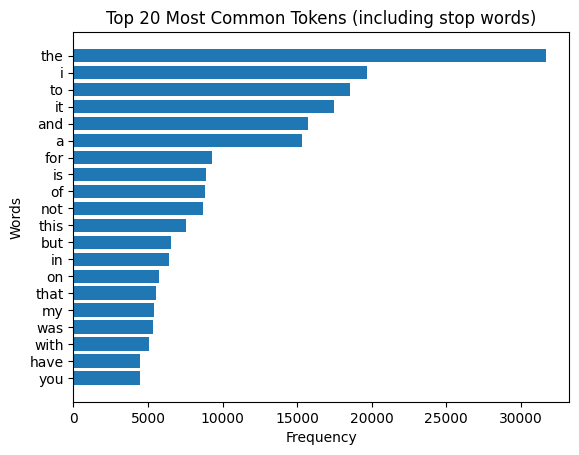

In [35]:
# Show the 20 most common words in the df (including stop words)
get_most_common_tokens(df, text_column='combined_text', top_n=20)

<b>Comment: </b> Indeed, tokens that are most common across the dataset are function words. These will need to be eliminated in the preprocessing. The function words 'not' shows high frequency and it's co-occurance with other words should be evaluated before removal.

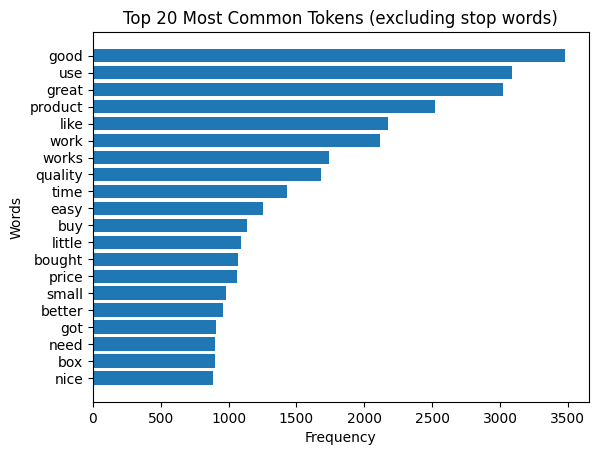

In [36]:
# Show the 20 most common words in the df (excluding stop words)
get_most_common_tokens(df, text_column='combined_text', top_n=20, stop_words=False)

<b>Comment: </b> Words such as 'product', 'buy', 'bought', 'got' likely do not add any value to the sentiment analysis and will be removed in preprocessing.



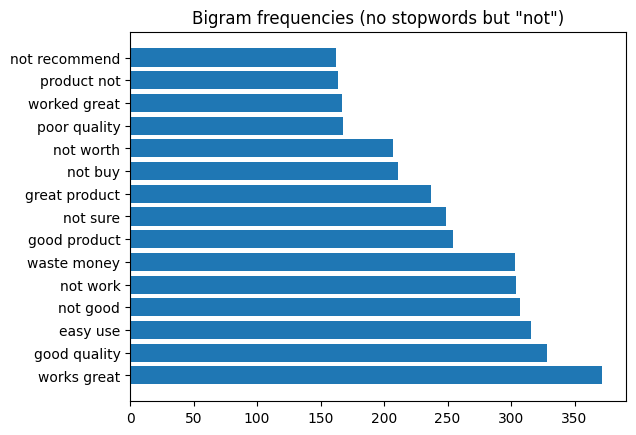

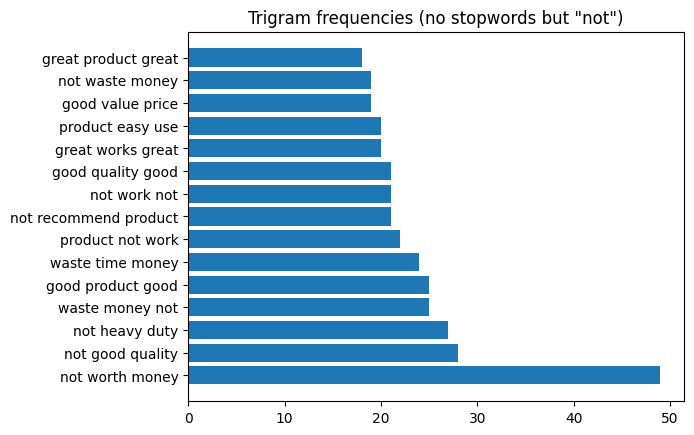

In [37]:
# Get most common ngrams (excluding stopwords)

#  Use nlp.pipe to process texts in batches
all_words = []
for doc in nlp.pipe(df['combined_text'], batch_size=500, disable=["ner", "parser"]):
    words = [token.text.lower() for token in doc if token.is_alpha and not token.is_punct and (not token.is_stop or token.text.lower() == "not")]
    all_words.extend(words)

# Generate bigrams and trigrams
bigrams_ = list(ngrams(all_words, 2))
trigrams_ = list(ngrams(all_words, 3))

# Count frequencies using Counter
bg_freq = Counter(bigrams_)
tg_freq = Counter(trigrams_)

# Show the most common bigrams and trigrams
bg_freq_most_common = bg_freq.most_common(15)
tg_freq_most_common = tg_freq.most_common(15)

# Prepare data for plotting (convert tuple to string)
bgs_ = [' '.join(map(str, bg[0])) for bg in bg_freq_most_common]
bgs_f_ = [bg[1] for bg in bg_freq_most_common]

tgs_ = [' '.join(map(str, tg[0])) for tg in tg_freq_most_common]
tgs_f_ = [tg[1] for tg in tg_freq_most_common]

# Plot bigram frequencies
plt.barh(bgs_, bgs_f_)
plt.title('Bigram frequencies (no stopwords but "not")')
plt.show()

# Plot trigram frequencies
plt.barh(tgs_, tgs_f_)
plt.title('Trigram frequencies (no stopwords but "not")')
plt.show()

<b>Comment: </b>
It's clear that 'not' is important to retain for sentiment analysis, e.g. from it's combination with 'buy', 'worth', 'good'. Token 'buy' should also be retained.

Tokens that can be eliminated in preprocessing as they do not add any information beyond words they co-occur with:
- 'product'
- 'quality'
- 'money'
- 'price'
- 'time'

#### Find most common tokens and ngrams per rating

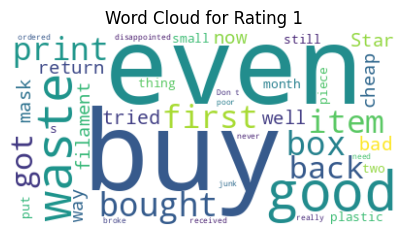

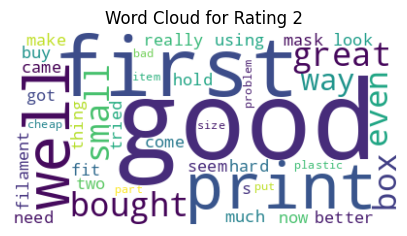

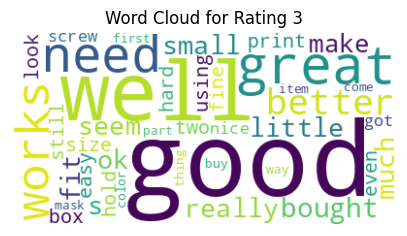

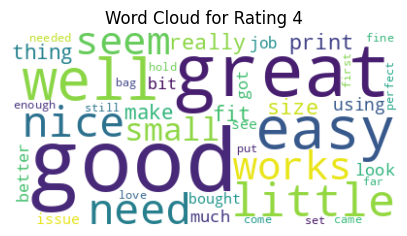

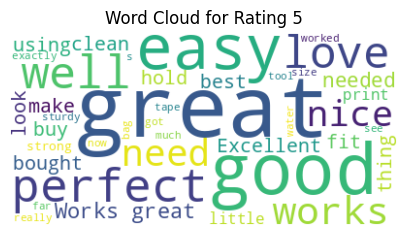

In [38]:
# Visualize word cloud per rating

for rating, group in df.groupby('rating'):
    # Combine all the 'combined_text' for the current rating group
    combined_text = " ".join(group['combined_text'])

    # Initialize the WordCloud
    wc = WordCloud(
        background_color='white',
        max_words=40,
        stopwords=STOPWORDS.update(['br', 'work', 'used', 'use', 'product', 'price', 'money', 'quality', 'time', 'one', 'will'])
    )

    # Generate the word cloud
    wc_image = wc.generate(combined_text)

    # Display the word cloud
    plt.figure(figsize=(5, 5))
    plt.imshow(wc_image, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for Rating {rating}")
    plt.show()


<b>Comment: </b> The token 'good' appears across all ratings, from positive to negative. From the previous ngram analysis, it is likely coupled with 'not' for the lower ratings. The following analysis checks this aspect.
The preprocessing should correct spelling (word clouds contained tokens such as "s").

In [39]:
# Function to generate ngrams per rating
def ngrams_per_rating(df, n=2):
    # Dictionary to store ngrams (bigrams, trigrams, etc.) for each rating
    ngram_counts = {}

    # Group the DataFrame by rating
    for rating, group in df.groupby('rating'):
        all_words = []

        # Use nlp.pipe to process texts in batches
        for doc in nlp.pipe(group['combined_text'], batch_size=500, disable=["ner", "parser"]):
            # Extract words (tokens) from each document
            words = [token.text.lower() for token in doc if token.is_alpha and not token.is_punct and (not token.is_stop or token.text.lower() == "not")]
            all_words.extend(words)

        # Generate and count ngrams for each rating category
        ngrams_ = list(ngrams(all_words, n))
        ngram_freq = Counter(ngrams_)

        # Store ngram frequencies for each rating
        ngram_counts[rating] = ngram_freq

    return ngram_counts

# Function to display most common ngrams per rating
def plot_ngrams(ngram_counts, top_n=15, type='bigram'):
    for rating, ngram_freq in ngram_counts.items():
        # Get the most common ngrams for the current rating
        most_common_ngrams = ngram_freq.most_common(top_n)

        # Unzip the ngrams and their frequencies
        ngrams, freqs = zip(*most_common_ngrams)

        # Convert ngrams from tuples to string format
        grams = [' '.join(ngram) for ngram in ngrams]

        # Plot the ngram frequencies
        plt.figure(figsize=(5, 3))
        plt.barh(grams, freqs)
        plt.xlabel('Frequency')
        if type == 'bigram':
            plt.title(f'{top_n} Most Common Bigrams for Rating {rating}')
        else:
            plt.title(f'{top_n} Most Common Trigrams for Rating {rating}')
        plt.show()


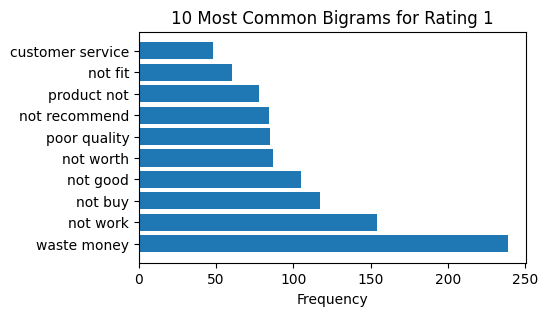

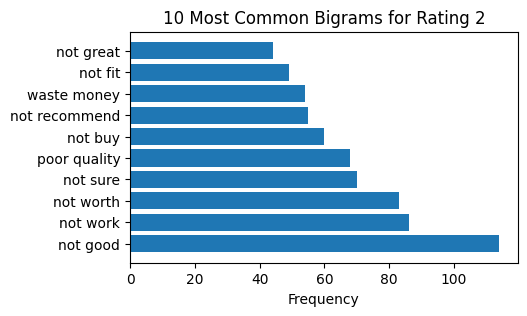

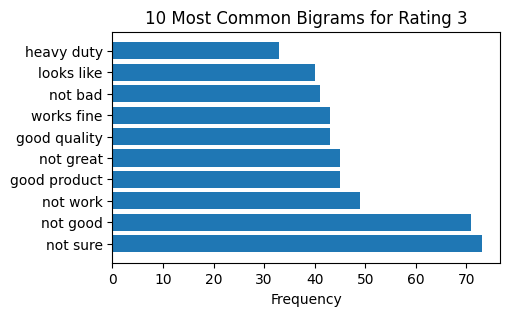

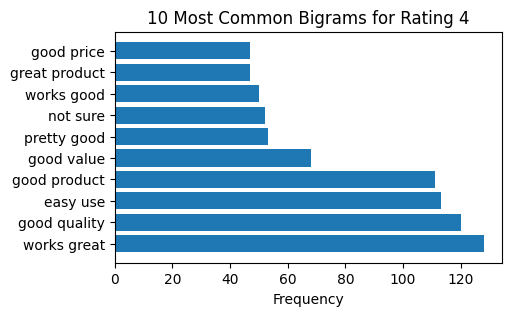

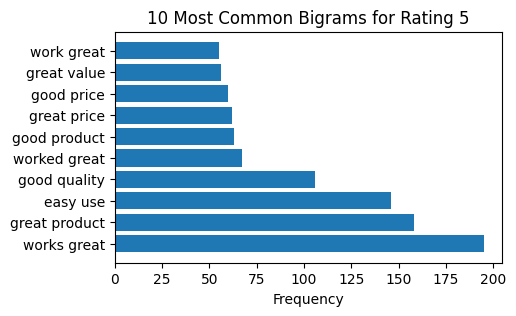

In [40]:
# Get bigrams for each rating category
bigram_counts = ngrams_per_rating(df, n=2)

# Plot bigrams per rating
plot_ngrams(bigram_counts, top_n=10, type='bigram')

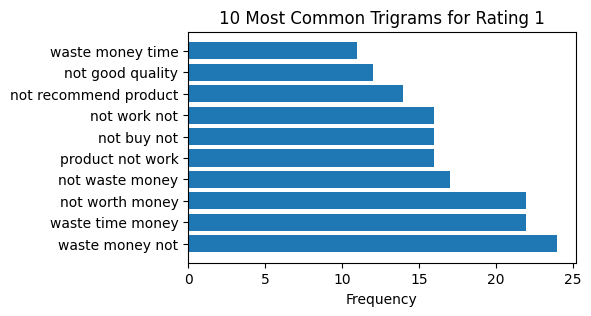

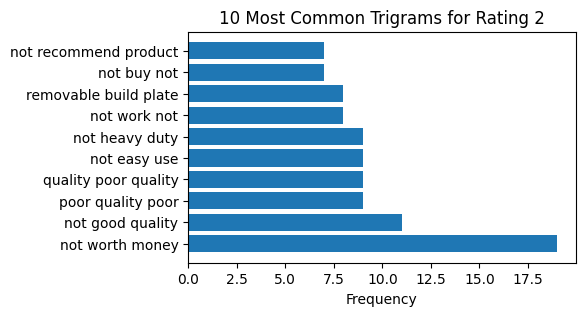

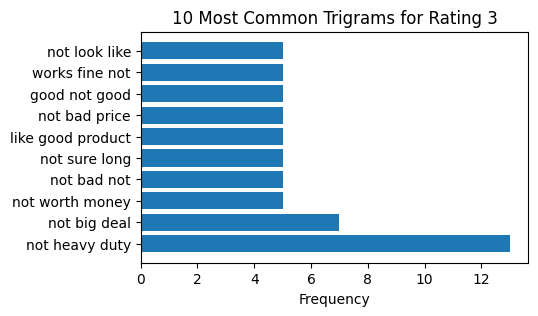

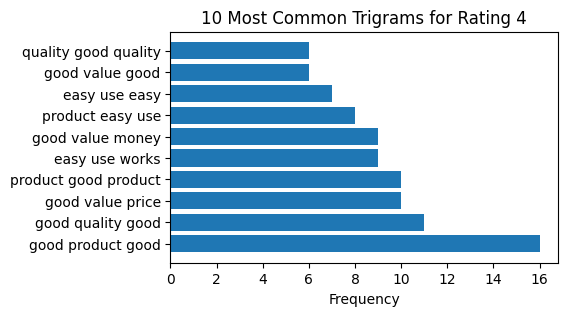

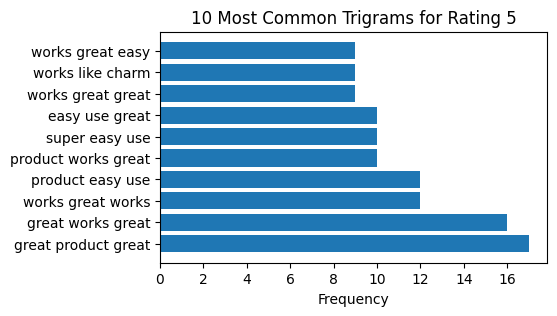

In [41]:
# Get trigrams for each rating category (optional)
trigram_counts = ngrams_per_rating(df, n=3)

# Plot trigrams per rating
plot_ngrams(trigram_counts, top_n=10, type='trigram')

<b>Comment: </b> Based on the common ngrams per rating, differences between rating 1 and 2 are more difficult to distinguish. The other ratings have more visible gradation roughly from 'not bad', 'good', to 'great'.


#### Visualize word embeddings of selected tokens

In [42]:
# Load SpaCy model
nlp = spacy.load('en_core_web_lg')

# Function to tokenize text and exclude stopwords
def tokenize_exclude_stopwords(text, nlp):
    doc = nlp(text)
    return [token.text.lower() for token in doc if token.is_alpha and not token.is_stop]

# Tokenize sentences for Word2Vec
sentences = [tokenize_exclude_stopwords(doc, nlp) for doc in df['combined_text']]
w2v_model = Word2Vec(min_count=20,
                     window=4,
                     vector_size=512,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20)

w2v_model.build_vocab(sentences, progress_per=10000)
print(f"Total number of tokens in vocabulary: {len(w2v_model.wv.key_to_index)}")
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

# Words for visualization
keys = ['product', 'quality', 'money', 'time']


Total number of tokens in vocabulary: 2182


In [43]:
# Collect embeddings and word clusters
embedding_clusters = []
word_clusters = []
for word in keys:
    if word in w2v_model.wv:
        embeddings = []
        words = []
        for similar_word, _ in w2v_model.wv.most_similar(word, topn=10):
            words.append(similar_word)
            embeddings.append(w2v_model.wv[similar_word])
        embedding_clusters.append(embeddings)
        word_clusters.append(words)
    else:
        print(f"Word '{word}' not in vocabulary.")

In [44]:
# Dimensionality reduction using t-SNE
tsne_model_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
embeddings_2d = np.array(tsne_model_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


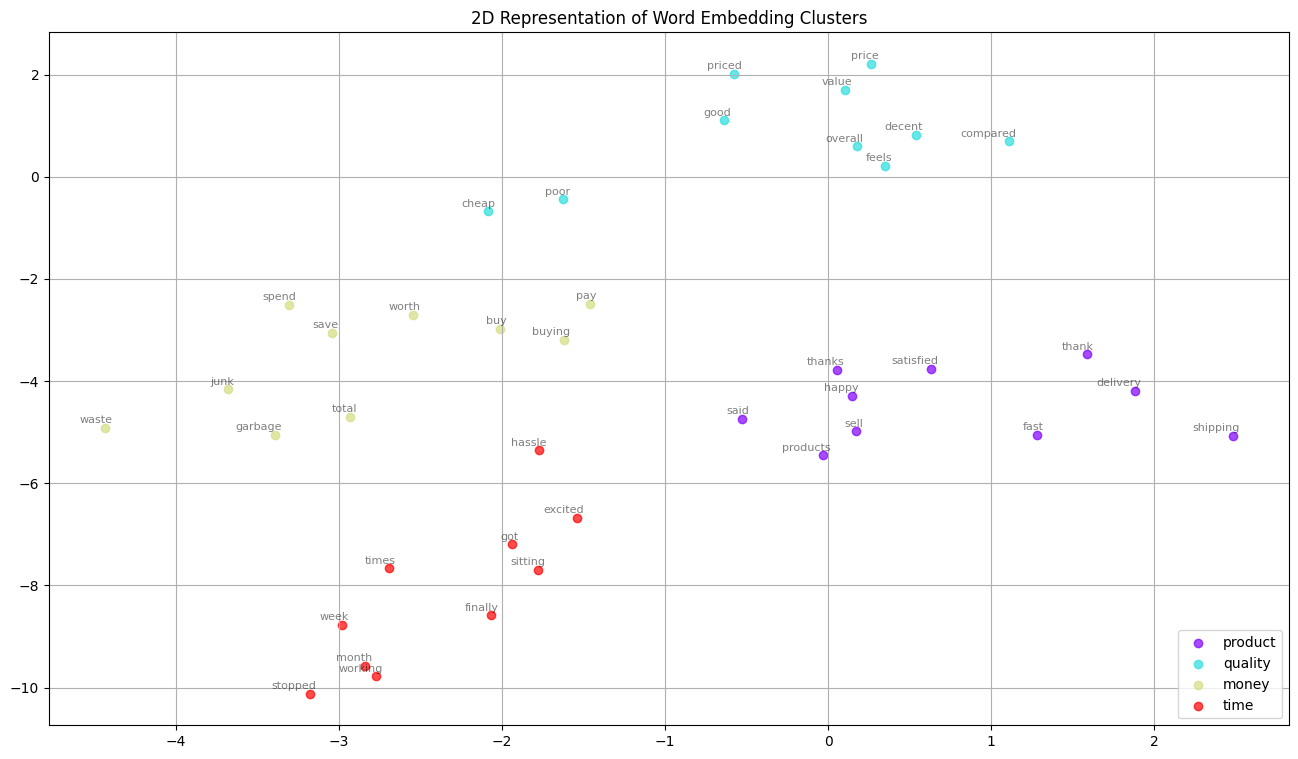

In [45]:
# Visualization function
def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=[color], alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.grid(True)
    plt.title('2D Representation of Word Embedding Clusters')
    plt.show()

# Visualize the embeddings
tsne_plot_similar_words(keys, embeddings_2d, word_clusters)